# Hackathon 6

Written by Eleanor Quint

Topics:
- Techniques for dimension expansion
    - Transpose convolutions
    - Sub-pixel convolutions
    - ProgressiveGAN upscaling
- Autoencoding
    - Sparse autoencoders
    - De-noising autoencoders

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import os  # to work with file paths

import tensorflow as tf         # to specify and run computation graphs
import numpy as np              # for numerical operations taking place outside of the TF graph
import matplotlib.pyplot as plt # to draw plots

mnist_dir = '/work/cse496dl/shared/hackathon/03/mnist/'
cifar_dir = '/work/cse496dl/shared/hackathon/05/'

In [2]:
# extract our dataset, MNIST
train_data = np.load(mnist_dir + 'mnist_train_images.npy')
train_data = np.reshape(train_data, [-1, 28, 28, 1])
test_data = np.load(mnist_dir + 'mnist_test_images.npy')
test_data = np.reshape(test_data, [-1, 28, 28, 1])

### Techniques for dimension expansion

Generally we compress high dimensional representations into lower dimensional ones. Now, we're going to study ways of going from lower dimensional to higher. For this, we're going to define a function `upscale_block` in three different ways.

#### Transpose convolutions

Although we can reverse linear transformations very easily, images are less straightforward to upscale. Aside from naive, classical techniques for upscaling, we can learn to increase the size of images with transpose convolutions. They are sometimes called "deconvolutions" because they're the inverse operation of the convolution, but it is actually the transpose (gradient) of conv2d rather than an actual deconvolution. Transpose convolutions are implemented by [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose).

In [3]:
def upscale_block(x, scale=2):
    """ conv2d_transpose """
    return tf.layers.conv2d_transpose(x, 3, 3, strides=(scale, scale), padding='same', activation=tf.nn.relu)

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
up_x = upscale_block(x)
print(up_x)
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

Tensor("conv2d_transpose/Relu:0", shape=(?, 64, 64, 3), dtype=float32)
Parameters: 84


#### Sub-pixel convolutions

Another approach is called the sub-pixel convolution, which does a convolution with many channels, and then re-orders the data into the height and width dimensions from the channels dimension:

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/03a5b2aac53443e6078f0f63b35d4f95d6d54c5d/2-Figure1-1.png">

(Image sourced from [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158))

In [4]:
def upscale_block(x, scale=2):
    """ [Sub-Pixel Convolution](https://arxiv.org/abs/1609.05158) """
    n, w, h, c = x.get_shape().as_list()
    x = tf.layers.conv2d(x, c * scale ** 2, (3, 3), activation=tf.nn.relu, padding='same')
    output = tf.depth_to_space(x, scale)
    return output
    
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
x_up = upscale_block(x)
print(x_up)
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

Tensor("DepthToSpace:0", shape=(?, 64, 64, 3), dtype=float32)
Parameters: 336


#### ProgressiveGAN upscaling

Finally, one technique that's recently found massive success in Nvidia's ProgressiveGAN used to generate high-resolution fake celebrity faces:

<img src="https://i2.wp.com/robotnyheter.se/wp-content/uploads/2018/01/Nvidia_GAN_ansikten.jpg?w=1561">

None of these are real photos, they've all been upsampled from Gaussian noise with this technique

In [5]:
def upscale_block(x, scale=2):
    """ similar to the upsampling used in [ProgressiveGAN](https://arxiv.org/pdf/1710.10196.pdf) """
    n, w, h, c = x.get_shape().as_list()
    up_x = tf.image.resize_nearest_neighbor(x, [scale*h, scale*w])
    output = tf.layers.conv2d(up_x, 3, 3, padding='same', activation=tf.nn.relu)
    return output

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
x_up = upscale_block(x)
print(x_up)
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

Tensor("conv2d/Relu:0", shape=(?, 64, 64, 3), dtype=float32)
Parameters: 84


### Autoencoding

Generally, autoencoding is learning "a complicated identity function". This makes it a form of unsupervised learning, which doesn't require data to be explicitly labeled, but instead looks for patterns and trends in data. Typically the complication is to bottleneck the size of the representation, but can also be more varied. We'll look at code for sparse autoencoders and de-noising autoencoders.

First we'll define some preliminaries that we'll use in both architectures:

In [24]:
def upscale_block(x, scale=2):
    """transpose convolution upscale"""
    return tf.layers.conv2d_transpose(x, 1, 3, strides=(scale, scale), padding='same', activation=tf.nn.relu)

def downscale_block(x, scale=2):
    n, h, w, c = x.get_shape().as_list()
    return tf.layers.conv2d(x, np.floor(c * 1.25), 3, strides=scale, padding='same')

def autoencoder_network(x, code_size=100):
    """This network assumes [?, 28, 28, ?] shaped input"""
    encoder_14 = downscale_block(x)
    encoder_7 = downscale_block(encoder_14)
    flatten_dim = np.prod(encoder_7.get_shape().as_list()[1:])
    print(flatten_dim)
    flat = tf.reshape(encoder_7, [-1, flatten_dim])
    print(flat.get_shape().as_list())
    code = tf.layers.dense(flat, code_size, activation=tf.nn.relu)
    hidden_decoder = tf.layers.dense(code, 49, activation=tf.nn.elu)
    decoder_7 = tf.reshape(hidden_decoder, [-1, 7, 7, 1])
    decoder_14 = upscale_block(decoder_7)
    output = upscale_block(decoder_14)
    return code, output

#### Sparse autoenoding

Although we bottleneck the representation in normal autoencoding by reducing the dimensionality, sparse autoencoders can actually increase it, but restrict it to be sparsely activated with L1 regularization using [tf.norm](https://www.tensorflow.org/api_docs/python/tf/norm) or KL-divergence. This has the effect of only having non-zero values in a few dimensions, effectively bottlenecking each representation, but giving a greater variety of dimensions to choose to be used.

In [25]:
# set hyperparameters
sparsity_weight = 5e-3
code_size = 100

# define graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
code, outputs = autoencoder_network(x, code_size)

# just for fun
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

# calculate loss
sparsity_loss = tf.norm(code, ord=1, axis=1)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x)) # Mean Square Error
total_loss = reconstruction_loss + sparsity_weight * sparsity_loss

# setup optimizer
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(total_loss)

# train for an epoch
batch_size = 16
session = tf.Session()
session.run(tf.global_variables_initializer())
for epoch in range(1):
    for i in range(train_data.shape[0] // batch_size):
        batch_xs = train_data[i*batch_size:(i+1)*batch_size, :]
        session.run(train_op, {x: batch_xs})
print("Done!")

49
[None, 49]
Parameters: 9989
Done!


Let's 

Code and Input
[[-0.         -0.         -0.          0.20856217 -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.        

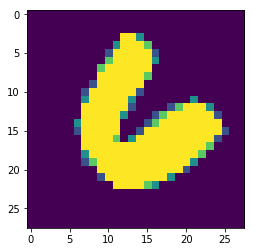

In [8]:
# run a test
idx = np.random.randint(test_data.shape[0])
x_out, code_out, output_out = session.run([x, code, outputs], {x: np.expand_dims(test_data[idx], axis=0)})
print("Code and Input")
plt.imshow(np.squeeze(x_out))
print(code_out)
print("Number of nonzero code dimensions: {}/{}".format(np.count_nonzero(code_out), code_size))

Reconstruction


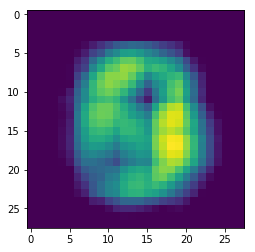

In [9]:
# Show reconstruction
# This is in a different cell from the last plt.imshow call to show 2 images at once
print("Reconstruction")
plt.imshow(np.squeeze(output_out))

#### Denoising Autoencoder

Another way to force the an autoencoder to learn the features of data is to force it to map noisy, corrupted versions of the data back to the original. This is usually accomplished by manually adding noice (e.g., Gaussian), but may also be useful in real world settings.

The noise level could be scaled up as training proceeds to implement a form of [curriculum learning](https://ronan.collobert.com/pub/matos/2009_curriculum_icml.pdf).

In [10]:
# hyperparameters
noise_level = 0.1
code_size = 40

# define graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
x_noisy = x + noise_level * tf.random_normal(tf.shape(x))
code, outputs = autoencoder_network(x_noisy, code_size=code_size)

# calculate loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x)) # MSE
total_loss = reconstruction_loss # just for consistency

# setup optimizer
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(total_loss)

# train for an epoch and visualize
batch_size = 16
session = tf.Session()
session.run(tf.global_variables_initializer())
for epoch in range(2):
    for i in range(train_data.shape[0] // batch_size):
        batch_xs = train_data[i*batch_size:(i+1)*batch_size, :]
        session.run(train_op, {x: batch_xs})
print("Done!")

Done!


Input


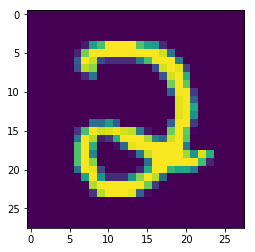

In [11]:
# run a test
idx = np.random.randint(test_data.shape[0])
x_out, noisy_x_out, code_out, output_out = session.run([x, x_noisy, code, outputs], {x: np.expand_dims(test_data[idx], axis=0)})
print("Input")
plt.imshow(np.squeeze(x_out))

Code and Noised Input
[[ 1.5743738   0.6725889   0.20697011  0.95573187  0.65809     0.78361917
   0.58643436  1.2584779   2.680713    0.89099556 -0.          1.1655937
   0.2197735  -0.          0.78997356  0.6262385   1.6427002   1.4157786
   1.0798181   0.5329313   0.76660866  1.410756    0.9152416   0.31690636
   0.70389783  1.941689    0.6171601   0.6058891   0.6166893  -0.
   0.89649117  0.47738117  0.60251623 -0.          0.845098    1.0776948
   0.3398206   0.50544214  0.6965709   0.692088  ]]
Number of nonzero code dimensions: 36/40


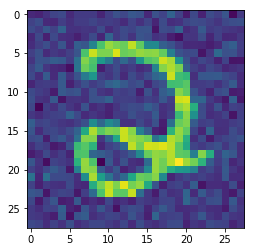

In [12]:
# show the noised input and code
plt.imshow(np.squeeze(noisy_x_out))
print("Code and Noised Input")
print(code_out)
print("Number of nonzero code dimensions: {}/{}".format(np.count_nonzero(code_out), code_size))

Reconstruction


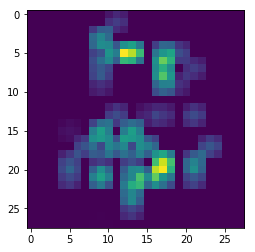

In [13]:
# Show reconstruction
# This has to be in a different cell from the last plt.imshow call to show 2 images at once
print("Reconstruction")
plt.imshow(np.squeeze(output_out))

## Hackathon 6 Exercise

Write code specifying an autoencoder with a code of shape `[None, 4, 4, 1]` with the provided input placeholder (corresponding to a color image like CIFAR-10). Specify a reasonable autoencoding loss function so that the given optimizer code runs.

In [29]:

def upscale_block_code(x, scale=1):
    """transpose convolution upscale"""
    return tf.layers.conv2d_transpose(x, 3, 3, strides=(scale, scale), padding='same', activation=tf.nn.relu)

def downscale_block_code(x, scale=1):
    n, h, w, c = x.get_shape().as_list()
    return tf.layers.conv2d(x, 1, 3, strides=scale, padding='same')

def autoencoder_network(x, code_size):
    '''This network has input size [None, 32, 32, 3]'''
    encoder_16 = downscale_block(x)
    encoder_8 = downscale_block(encoder_16)
    encoder_4 = downscale_block(encoder_8)
    encoder_4_filter_1=downscale_block_code(encoder_4)
    flatten_dim = np.prod(encoder_4_filter_1.get_shape().as_list()[1:])
    flat = tf.reshape(encoder_4_filter_1, [-1, flatten_dim])
    
    code = tf.layers.dense(encoder_4_filter_1, code_size, activation=tf.nn.relu)
    print("Code size",code.get_shape().as_list())
    hidden_decoder = tf.layers.dense(code, 16, activation=tf.nn.elu)
    decoder_4 = tf.reshape(hidden_decoder, [-1, 4, 4, 1])
    
    decoder_8 = upscale_block(decoder_4)
    decoder_16 = upscale_block(decoder_8)
    decoder_16_filter_1 = upscale_block(decoder_16)
    output = upscale_block_code(decoder_16_filter_1)
    print("output shape same as input shape",output.get_shape().as_list())
    return code, output

# define graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

code, outputs = autoencoder_network(x, 1)
# if your code works, this should have no problem
optimizer = tf.train.AdamOptimizer()

# calculate loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x)) # MSE
loss = reconstruction_loss # just for consistency
train_op = optimizer.minimize(loss)


Code size [None, 4, 4, 1]
output shape same as input shape [None, 32, 32, 3]


### Coda

#### [Progressive GAN latent space interpolation on Youtube](https://youtu.be/XOxxPcy5Gr4?t=1m48s)

#### [How to Use t-SNE Effectively (distill.pub)](https://distill.pub/2016/misread-tsne/)